# Homework 1 Section B: Named Entity Recognition (NER) with HMMs

### Milestone Submission Due: February 12, 2025 (11:59PM)
### Project Submission Due: February 21, 2025 (11:59PM)

## **Logistics**

### Notes: 
  
- You will **NOT** be submitting this .ipynb file. Please refer to the submission instructions in both the hw1 pdf shared with you and at the end of this notebook.
- Please complete the written questions in the same pdf document where you attempt Section A of the homework.
- Do **NOT** add, remove, or modify any imports across python source files. If you have any concerns regarding missing imports, please let course staff know through EdStem before attempting to change anything.
- Do **NOT** change any of the function headers and/or specs! The input(s) and output must perfectly match the specs, or else your implementation for any function with changed specs will most likely fail! (for e.g. do not shuffle your data when generating the output.txt file! )
- If you decide to create local helper functions, your code must have docstrings/comments documenting the meaning of parameters and important parameter-like variables.
- We are recommending python version 3.9+. This is due to compatibility issues with the external dependencies.


### Tips:
- Pair program the more intensive parts of this assignment! You'll thank yourselves later for the amount of trouble this helps you avoid.
- We recommend you start this assignment early and continue incrementally adding onto it!

## Part 0: Environment setup

**IMPORTANT:** Read the following file: `vscode-setup.md` to setup your environment for development including setting up VSCode, adding Python extensions, creating virtual environments, and installing dependencies.

In [14]:
### AUTORELOAD EXTENSION -- DO NOT MODIFY ###
%load_ext autoreload
%autoreload 2

[PER Gavin Fogel] is cool .
[ORG ZIFA] said [PER Renate Goetschl] of [LOC Austria] won the women's [MISC World Cup] downhill race in [LOC Germany]
True True
False False
False False
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
### IMPORTS -- DO NOT MODIFY ###
import json
import nltk
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from helpers import apply_smoothing, handle_unknown_words
from models import HMM
#from viterbi import viterbi
from validation import evaluate_model, mean_f1, format_output_labels
from data_exploration import unzip_data, read_json, stringify_labeled_doc, validate_ner_sequence

## Part 1: Data Exploration

### Loading the Data

The data is stored in a zip file. You can use the following provided function to
load the data and preprocess it. Under the hood, this is unzipping the data and reading each of
the provided json data files into Python dictionaries. It then further formats the data such that
we can accurately train our model from it.

In [16]:
data_zip_path = "./dataset.zip"
dest_path = "dataset"

unzip_data(data_zip_path, dest_path) # unzips the data into current directory

training_data = read_json(os.path.join(dest_path, "train.json"))
validation_data = read_json(os.path.join(dest_path, "val.json"))
test_data = read_json(os.path.join(dest_path, "test.json"))

training_data['text'] = [sen[:-1] for sen in training_data['text']]
validation_data['text'] = [sen[:-1] for sen in validation_data['text']]
test_data['text'] = [sen[:-1] for sen in test_data['text']]

training_data['NER'] = [sen[:-1] for sen in training_data['NER']]
validation_data['NER'] = [sen[:-1] for sen in validation_data['NER']]

training_data['index'] = [sen[:-1] for sen in training_data['index']]
validation_data['index'] = [sen[:-1] for sen in validation_data['index']]
test_data['index'] = [sen[:-1] for sen in test_data['index']]

### Looking at the data

Since your data files can be large and unwieldy, you can explore the data by
writing code. Check out the data format by looking at at keys, and some of the
values in the data. You can use the following code to get started:

In [17]:
print(training_data.keys())
print(validation_data.keys())
print(test_data.keys())

dict_keys(['index', 'text', 'NER'])
dict_keys(['index', 'text', 'NER'])
dict_keys(['index', 'text'])


Notice the test data does not have any labels. This is because you will need to
predict them using your models!

To get a sense of what your data looks like, check out some samples. Implement
the `stringify_labeled_doc` function in `data_exploration.py`, and use it to print
out some samples of the data.

In [18]:
random_index = random.randint(0, len(training_data['text']))
text = training_data['text'][random_index]
ner = training_data['NER'][random_index]
s = stringify_labeled_doc(text, ner)
print(s)

The Shah of [LOC Kabul] at this time was [PER Kamaluka] , called " [PER Kamalu] " in [MISC Persian] literature


#### Q1.1: Using the `stringify_labeled_doc` function you implemented, print 5 documents (sentences) from the training data which have at least 4 distinct tags (including 'O'). What do you notice? 

In [19]:
# YOUR CODE HERE
random_index1 = random.randint(0, len(training_data['text']))
text = training_data['text'][random_index1]
ner = training_data['NER'][random_index1]
s1 = stringify_labeled_doc(text, ner)
print(s1)
random_index2 = random.randint(0, len(training_data['text']))
text = training_data['text'][random_index2]
ner = training_data['NER'][random_index2]
s2 = stringify_labeled_doc(text, ner)
print(s2)
random_index3 = random.randint(0, len(training_data['text']))
text = training_data['text'][random_index3]
ner = training_data['NER'][random_index3]
s3 = stringify_labeled_doc(text, ner)
print(s3)
random_index4 = random.randint(0, len(training_data['text']))
text = training_data['text'][random_index4]
ner = training_data['NER'][random_index4]
s4 = stringify_labeled_doc(text, ner)
print(s4)
random_index5 = random.randint(0, len(training_data['text']))
text = training_data['text'][random_index5]
ner = training_data['NER'][random_index5]
s5 = stringify_labeled_doc(text, ner)
print(s5)

[LOC France] won on penalties when the game finished 0 – 0 after extra-time
He also was selected to play at the [MISC 2002 IIHF World U18 Championships] , in which he amassed 14 goals and four assists in eight games , leading [LOC Russia] to a silver medal
In general , the broadening is intermediate between [PER Lorentzian] and [PER Gaussian] ; for an alloy it is somewhat closer to [PER Gaussian] because of strong scattering from statistical fluctuations in the local composition on a nanometer scale
He dated model [PER China Chow] for three years
Early [MISC Christian] church leaders used the [MISC Greek] word " gnosis " ( knowledge ) to describe " spiritual knowledge "


### Validating the data

This data looks okay, _right?_ ... _right?_ The reality is that language data is
super messy. One option would be to look through every example by hand, but this
is impractical. Another option would be to write a program that could check if
each example is correct, but if you could do that, you wouldn't need to write
the program to do NER tagging in the first place! However, there is a middle
ground. If you had a programatic way to check the validity of the data, you
could catch some of these issues. Let's try to do that.

#### Q1.2: Implement the `validate_ner_sequence` function in `data_exploration.py` Are there any documents in the training data which have invalid labelings? If so, how many are there?

Hint: Think about what makes a valid sequence of labels under the BIO tagging scheme.

### Data Statistics

In order to look at the data in a different way, you can visualize some of its characteristics. Take the example
below, which shows the distribution of the number of tokens per document in the training data. You can use the following code to get started:

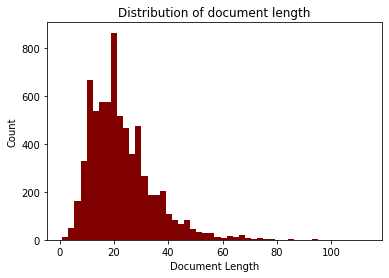

In [ ]:

doc_lengths = [len(doc) for doc in training_data["text"]]

def plot_histogram(data, title, xlabel, ylabel, bins=50):
    """
    Plots a histogram of the data.

    Input:
      data: List[Int], representing the data to be plotted
      title: String, representing the title of the plot
      x_label: String, representing the x-axis label
      y_label: String, representing the y-axis label
      i: Int, representing the figure number
    Output:
      None
    """
    plt.hist(data, bins=bins, color="maroon")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

plot_histogram(
		doc_lengths,
		"Distribution of document length",
		"Document Length",
		"Count",
)

#### Q1.3: Provide a bar graph giving the token level distribution of NER tags, (O included): e.g. 10% of tokens are B-ORG, 20% of tokens are I-ORG, etc. What do you notice about this distribution? Is this what you might expect? What difficulties might this cause for your models?

Token-level distribution of NER tags:
  O: 87.78%
  B-MISC: 1.74%
  I-MISC: 1.58%
  B-LOC: 2.57%
  B-PER: 1.91%
  B-ORG: 1.19%
  I-LOC: 0.89%
  I-PER: 1.35%
  I-ORG: 1.00%


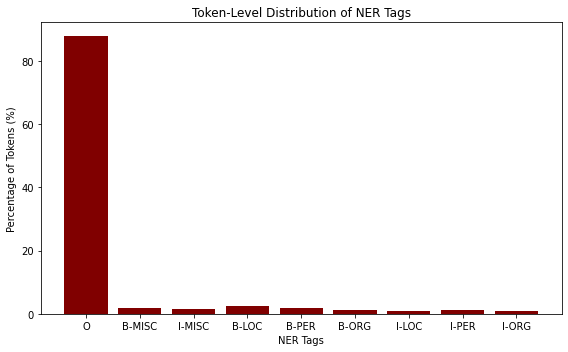

In [29]:
# YOUR CODE HERE

tag_counts = {}
for ner_tags in training_data['NER']:
    for tag in ner_tags:
        tag_counts[tag] = tag_counts.get(tag, 0) + 1

total_tokens = sum(tag_counts.values())

print("Token-level distribution of NER tags:")
for tag, count in tag_counts.items():
    percentage = (count / total_tokens) * 100
    print(f"  {tag}: {percentage:.2f}%")

# 3. Plot the distribution as a bar chart.
tags = list(tag_counts.keys())
counts = list(tag_counts.values())
percentages = [(count / total_tokens) * 100 for count in counts]

plt.figure(figsize=(8, 5))
plt.bar(tags, percentages, color='maroon')
plt.xlabel('NER Tags')
plt.ylabel('Percentage of Tokens (%)')
plt.title('Token-Level Distribution of NER Tags')
plt.tight_layout()
plt.show()


#### A high majority of the tokens are tagged as O. This is expected but this might cause difficulty and result in a high O bias. This can also cause poor recall on rare tags and the model will struggle to learn these tags well because there are fewer examples.

#### Q1.4: It seems to be that entity tokens are uppercase. Is this correct? Plot a 2x2 matrix displaying the counts, where one dimension represents whether a token is uppercase and the other dimension indicates whether the token is part of an entity. What do you notice about this distribution? Is this what you might expect?

In [12]:
!pip3 install pandas
import pandas as pd

# Example data:
# labeled_tokens = [
#     ("IBM", "B-ORG"),
#     ("headquartered", "O"),
#     ("IN", "O"),
#     ("NEW", "B-LOC"),
#     ("YORK", "I-LOC"),
#     ...
# ]

rows = []
for (tokens, tags) in zip(training_data["text"], training_data["NER"]):
    for token, tag in zip(tokens, tags):
        # 1. Check if token is uppercase
        is_upper = (token == token.upper())
         
        # 2. Check if token is entity
        is_entity = (tag != "O")
        
        # We'll store these as booleans or strings ("Uppercase"/"Not Uppercase", etc.)
        rows.append({
            "uppercase": is_upper,
            "entity": is_entity
        })

df = pd.DataFrame(rows)

# Now create the 2x2 cross-tab:
crosstab = pd.crosstab(df["uppercase"], df["entity"])
print(crosstab)



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
entity      False  True 
uppercase               
False      118344  18270
True        21081   1142


#### Q1.5: Provide a list of the 10 tokens which are most frequently tagged as part of a named entity. What do you notice about this distribution? What difficulties might this cause for your models?

For examples if
- tokens = ["Cornell", "University", "is", "a", "university", "in", "Ithaca", ",", "New", "York"]
- tags   = ["B-ORG", "I-ORG", "O", "O", "O", "O", "B-LOC", "O", "B-LOC", "I-LOC"]

In this example, there are 3 named entities:
- ["Cornell University", "Ithaca", "New York"].

However, you are only interested in tokens which are tagged as part of named entities, which would be ["Cornell", "University, "Ithaca", "New", "York"].

In [13]:
# YOUR CODE HERE
named_counts = {}

for tokens, ner_tags in zip(training_data['text'], training_data['NER']):
    for token, tag in zip(tokens, ner_tags):
        if tag and tag[0] in {"B", "I"}:
            # Use .get(...) to default to 0 if the token is not yet in named_counts
            named_counts[token] = named_counts.get(token, 0) + 1

top10 = sorted(named_counts.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 most frequent named entity tokens:")
for token, count in top10:
    print(f"{token}: {count}")


Top 10 most frequent named entity tokens:
of: 286
The: 126
the: 121
New: 86
World: 85
United: 85
War: 74
States: 70
John: 63
and: 60


#### Some tokens like New and United and States are part of well known named entities like New York and United States. This results in more context dependent inferences and could result in some biases.

#### Q1.6: Provide a scatter plot mapping the length of a document to the number of named entities in that document. Describe what the plot looks like, and what it might mean about the relationship between named entities and document length.

In [ ]:
# YOUR CODE HERE

#### Q1.7: Make a convincing arugment around a novel insight about the data. In only a few sentences, argue why this insight is important in understanding the data for this task, and support your answer with relevant graphs or statistics.

In [ ]:
# YOUR CODE HERE

## Part 2: Hidden Markov Model
In this part of the assignment, you will:
1. Implement code for counting and smoothing of labels and words, as well as unknown word handing, as necessary to support the Viterbi algorithm.
2. Build a Hidden Markov Model in accordance with the starter code that has been provided in `models.py`.
3. Implement the **Viterbi algorithm**, that can be used to infer token-level labels (identifying the appropriate named entity) for an input document. This process is commonly referred to as **decoding**. Bigram-based Viterbi is $ \mathcal{O}(sm^2)$ where *s* is the length of the sentence and *m* is the number of tags. Your implementation should have similar efficiency. 

### Unknown Word Handling
---
Handling unknown words is essential for improving the robustness of your sequence tagging model. When your model encounters words that were not present in the training data, it might struggle to make accurate predictions.

In this section, you will complete `handle_unknown_words(t, documents)` function in `helpers.py` The unknown word handling function replaces infrequently occurring words in the text data with a special "\<unk\>" token. This ensures that words with low occurrence are not treated as unique and distinct, allowing the model to recognize them as a common unknown category. By doing so, the method helps the model maintain consistent performance when dealing with unfamiliar or rare words, enhancing its ability to handle unseen data effectively.

Detailed specs about expected inputs and outputs are outlined in `helpers.py`. It injests the tokenized documents of a corpus (e.g. the training_data["text"] from above) and returns a tokenized document corpus with infrequent words replaced by "\<unk\>", as well as the resulting vocab.

After you complete the function, you may run the following basic test case. Passing this test does NOT guarantee correctness and it is a good idea to write some tests of your own.

In [43]:
t = 0.3  #see helpers.py for information about this parameter means
documents = [["good", "morning"], ["is", "good", "morning"], ["hello"]]
expected_new_documents = [["good", "morning"], ["is", "good", "morning"], ["<unk>"]]  
expected_vocab = ["good", "morning", "is", "<unk>"]  
new_documents, vocab = handle_unknown_words(t, documents)

print(expected_new_documents)
print(new_documents)

assert expected_new_documents == new_documents
assert sorted(expected_vocab) == sorted(vocab)

[['good', 'morning'], ['is', 'good', 'morning'], ['<unk>']]
[['good', 'morning'], ['is', 'good', 'morning'], ['<unk>']]


### Smoothing
---
Smoothing makes our sequence tagging model more resilient to unexpected words and rare patterns, improving its ability to predict accurately on unseen data.

In this section, you will complete `apply_smoothing(k, observation_counts, unique_obs)` function in `helpers.py` file. The function implements an add-k smoothing. It adds a constant value (k) to each count before calculating probabilities, ensuring that no count is zero and that probabilities are never zero. While there are more advanced smoothing techniques, add-k smoothing provides a good starting point for handling the challenges of sparse data in probabilistic modeling.

For example, given an unsmoothed frequency count
```
unsmoothed_counts = {
    ('PER', 'John'): 3,
    ('PER', 'Google'): 0,
    ('PER', 'California'): 0,
    ('PER', 'works'): 0,
    ('PER', 'at'): 0,
    ('ORG', 'Google'): 2,
    ('ORG', 'John'): 0,
    ('ORG', 'California'): 0,
    ('ORG', 'works'): 0,
    ('ORG', 'at'): 0,
    ('LOC', 'Google'): 0,
    ('LOC', 'John'): 0,
    ('LOC', 'California'): 1,
    ('LOC', 'works'): 0,
    ('LOC', 'at'): 0,
    ('O', 'Google'): 0,
    ('O', 'John'): 0,
    ('O', 'California'): 0,
    ('O', 'works'): 4,
    ('O', 'at'): 5,
}
```
the smoothed add-1 frequency count should be
```
smoothed_counts = {
    ('PER', 'John'): 3 + 1,
    ('PER', 'Google'): 0 + 1,
    ('PER', 'California'): 0 + 1,
    ('PER', 'works'): 0 + 1,
    ('PER', 'at'): 0 + 1,
    ('ORG', 'Google'): 2 + 1,
    ('ORG', 'John'): 0 + 1,
    ('ORG', 'California'): 0 + 1,
    ('ORG', 'works'): 0 + 1,
    ('ORG', 'at'): 0 + 1,
    ...same for 'LOC' and 'O'
}
```
and the smoothed add-1 probability would be
```
smoothed_prob = {
    ('PER', 'John'): (3 + 1) / (3 + 1 + 0 + 1 + 0 + 1 + 0 + 1 + 0 + 1),
    ('PER', 'Google'): (0 + 1) / (3 + 1 + 0 + 1 + 0 + 1 + 0 + 1 + 0 + 1),
    ('PER', 'California'): (0 + 1) / (3 + 1 + 0 + 1 + 0 + 1 + 0 + 1 + 0 + 1),
    ('PER', 'works'): (0 + 1) / (3 + 1 + 0 + 1 + 0 + 1 + 0 + 1 + 0 + 1),
    ('PER', 'at'): (0 + 1) / (3 + 1 + 0 + 1 + 0 + 1 + 0 + 1 + 0 + 1),
    ('ORG', 'Google'): (2 + 1) / (2 + 1 + 0 + 1 + 0 + 1 + 0 + 1 + 0 + 1),
    ...
}
```
Note when you call `apply_smoothing` function later in the HMM, the input `observation_counts` should contain counts for all possible `(curr NER tag, next NER tag)` pairs for transition matrix and `(NER tag, word)` pairs for emission matrix. i.e. if a `(NER tag, word)` doesn't appear in the training data, you should still include it as `observation_counts[(NER tag, word)]=0`.

After you complete the function, you may run the following basic test case. Passing this test does NOT guarantee correctness and it is a good idea to write some tests of your own. <br>

**NOTE: This example uses entity tags, but you should be using BIO tags in the assignment (ex: B-ORG, I-ORG, B-PER, I-PER, B-LOC, I-LOC, B-MISC, I-MISC, O).**

**In your implementation, you should store values in the log space**

In [44]:
k = 1
test_counts = {
    ('PER', 'John'): 3,
    ('PER', 'Google'): 0,
    ('PER', 'California'): 0,
    ('PER', 'works'): 0,
    ('PER', 'at'): 0,
    ('ORG', 'Google'): 2,
    ('ORG', 'John'): 0,
    ('ORG', 'California'): 0,
    ('ORG', 'works'): 0,
    ('ORG', 'at'): 0,
    ('LOC', 'Google'): 0,
    ('LOC', 'John'): 0,
    ('LOC', 'California'): 1,
    ('LOC', 'works'): 0,
    ('LOC', 'at'): 0,
    ('O', 'Google'): 0,
    ('O', 'John'): 0,
    ('O', 'California'): 0,
    ('O', 'works'): 4,
    ('O', 'at'): 5,
}

expected_log_smoothed_probs = {
    ('PER', 'John'): np.log(4/8),
    ('PER', 'Google'): np.log(1/8),
    ('PER', 'California'): np.log(1/8),
    ('PER', 'works'): np.log(1/8),
    ('PER', 'at'): np.log(1/8),
    ('ORG', 'Google'): np.log(3/7),
    ('ORG', 'John'): np.log(1/7),
    ('ORG', 'California'): np.log(1/7),
    ('ORG', 'works'): np.log(1/7),
    ('ORG', 'at'): np.log(1/7),
    ('LOC', 'Google'): np.log(1/6),
    ('LOC', 'John'): np.log(1/6),
    ('LOC', 'California'): np.log(2/6),
    ('LOC', 'works'): np.log(1/6),
    ('LOC', 'at'): np.log(1/6),
    ('O', 'Google'): np.log(1/14),
    ('O', 'John'): np.log(1/14),
    ('O', 'California'): np.log(1/14),
    ('O', 'works'): np.log(5/14),
    ('O', 'at'): np.log(6/14),
}

vocab = ['John', 'Google', 'California', 'works', 'at']

log_smoothed_probs = apply_smoothing(k, test_counts, vocab)

assert len(expected_log_smoothed_probs) == len(log_smoothed_probs)
for key in test_counts:
    np.testing.assert_almost_equal(expected_log_smoothed_probs[key], log_smoothed_probs[key])

### Milestone submission

You can make a milestone submission here. You need to submit your `helpers.py' file to hw1-milestone. The output of this function is expected to be a Python dictionary, where the keys are state-observation tuples, and the corresponding values are the log smoothed observation probabilities. We will not check if the values are exactly correct for the milestone submission, but we will run a basic sanity test to check that your returned dictionary does not contain any 0 probability (or -inf log probability values). 

In particular, we will check to ensure that all (NER tag, word) pairs with 0 observation counts have been included and assigned log smoothed probabilities.

### **HMM Class Implementation**
---
In this section, you will be implementing the HMM class using the following properties.


- **documents**: dataset of sentences to train model
- **labels**: NER labels corresponding the sentences to train model
- **vocab**: dataset vocabulary
- **all_tags**: all possible NER tags
- **k_t**: add-k parameter to smooth transition probabilities
- **k_e**: add-k parameter to smooth emission probabilities
- **k_s**: add-k parameter to smooth starting state probabilities
- **smoothing_func**: smoothing function to smooth state-observation probabilities


In the `model.py` file, complete following methods under the HMM class:
1. `build_transition_matrix()`: returns the transition probabilities as a dictionary, mapping all possible (tag, tag) tuple pairs to their corresponding smoothed log probabilities. See function declaration for more details.

2. `build_emission_matrix()`:
    returns the emission probabilities as a dictionary, mapping all possible
    (tag, token) tuple pairs to their corresponding smoothed log probabilities. See function declaration for more details.
    
3. `get_start_state_probs()`:
    returns the starting state probabilities as a dictionary, mapping all possible
    tags to their corresponding smoothed log probabilities. See function declaration for more details.
      
4. `get_tag_likelihood(predicted_tag, previous_tag, document, i)`
     returns the tag likelihood used by the Viterbi algorithm for the log probability of a given
    predicted_tag conditioned on the previous_tag and document at index i. See function declaration for more details.

To help you check your implementation, we give you a toy example with only 3 tags: ["B-PER", "O", "B-LOC"]. You may run this following basic test case to test your implementation of build_transition_matrix() and build_emission_matrix(). Passing this test does NOT guarantee correctness and it is a good idea to write some tests of your own. 

In [45]:
toy_hmm_documents = [['Alice', 'and', 'Bob', 'walk', 'in', 'Paris'], ['Bob', 'and', 'Alice', 'walk', 'in', 'Paris']]
toy_hmm_vocab = list(set([item for sublist in toy_hmm_documents for item in sublist]))
toy_hmm_ner_tags = [['B-PER', 'O', 'B-PER', 'O', 'O', 'B-LOC'], ['B-PER', 'O', 'B-PER', 'O', 'O', 'B-LOC']]
print(toy_hmm_ner_tags)
print(toy_hmm_vocab)
test_hmm_all_tags = list(set([item for sublist in toy_hmm_ner_tags for item in sublist]))
test_hmm = HMM(toy_hmm_documents, toy_hmm_ner_tags, toy_hmm_vocab, test_hmm_all_tags, 
          k_t=1, k_e=1, k_s=1, smoothing_func=apply_smoothing)
true_emission_matrix = {
    ('B-LOC', 'Bob'): np.log(1/8), 
    ('B-LOC', 'Alice'): np.log(1/8), 
    ('B-LOC', 'in'): np.log(1/8), 
    ('B-LOC', 'and'): np.log(1/8), 
    ('B-LOC', 'Paris'): np.log(3/8), 
    ('B-LOC', 'walk'): np.log(1/8), 
    ('B-PER', 'Bob'): np.log(3/10), 
    ('B-PER', 'Alice'): np.log(3/10), 
    ('B-PER', 'in'): np.log(1/10), 
    ('B-PER', 'and'): np.log(1/10), 
    ('B-PER', 'Paris'): np.log(1/10), 
    ('B-PER', 'walk'): np.log(1/10), 
    ('O', 'Bob'): np.log(1/12), 
    ('O', 'Alice'): np.log(1/12), 
    ('O', 'in'): np.log(3/12), 
    ('O', 'and'): np.log(3/12), 
    ('O', 'Paris'): np.log(1/12), 
    ('O', 'walk'): np.log(3/12)
}

true_transition_matrix = {
    ('B-LOC', 'B-LOC'): np.log(1/6), 
    ('B-LOC', 'B-PER'): np.log(1/6), 
    ('B-LOC', 'O'): np.log(1/6), 
    ('B-LOC', 'qf'): np.log(3/6), 
    ('B-PER', 'B-LOC'): np.log(1/8), 
    ('B-PER', 'B-PER'): np.log(1/8), 
    ('B-PER', 'O'): np.log(5/8), 
    ('B-PER', 'qf'): np.log(1/8), 
    ('O', 'B-LOC'): np.log(3/10), 
    ('O', 'B-PER'): np.log(3/10), 
    ('O', 'O'): np.log(3/10), 
    ('O', 'qf'): np.log(1/10)
}

for key in true_emission_matrix:
    np.testing.assert_almost_equal(true_emission_matrix[key], test_hmm.emission_matrix[key])
for key in true_transition_matrix:
    np.testing.assert_almost_equal(true_transition_matrix[key], test_hmm.transition_matrix[key])

[['B-PER', 'O', 'B-PER', 'O', 'O', 'B-LOC'], ['B-PER', 'O', 'B-PER', 'O', 'O', 'B-LOC']]
['walk', 'Alice', 'Bob', 'Paris', 'and', 'in']


NotImplementedError: 

If needed, you may extend the above example to test your implementation of get_tag_likelihood and get_start_state_probs functions as well.


After you completed the class methods, call the HMM constructor to train your model with the following criteria:
- Note that the input data to train your model will be the training_data["text"] and training_data["NER]
- First handle unknown words by using your function `handle_unknown_words` from Part 2.1 using a threshold t = 0.01. You should call this function only on the training dataset in this step. 
- When you call the HMM constructor, use the following smoothing parameters: k_t = 0.01, k_e = 0.01, k_s = 0.1. You should use your smoothing function that you have implemented in Part 2.2
- An example call to the HMM constructor is shown in the example above. Note that the values of all_tags and vocab will be different between the toy example above and your training data. 

In [ ]:
# YOUR CODE HERE 

### **Viterbi Implementation**
---
Implement the function `viterbi(model, observation)` in `viterbi.py` that returns the model's predicted tag sequence for a particular observation. After you have completed the function, use the following cell to see an example tagged sequence.

In [ ]:
tags = ["B-ORG", "I-ORG", "B-PER", "I-PER", "B-LOC", "I-LOC", "B-MISC", "I-MISC", "O"]
obs = ['The',
 'White',
 'house',
 'located',
 'in',
 'Ithaca',
 'and',
 'was',
 'founded',
 'by',
 'Ezra',
 'Cornell']

# Uncomment and fill out the following line to test your implementation:
# viterbi(hmm, obs, tags) #hmm is the trained model from the previous code block

### **Validation Step for HMM**
---
Understanding how models perform on unseen data is important, hence the validation set was set aside to be used in the evaluation of the model. In the previous part of the project, we expected you to train your HMM model (i.e., get transition and emission probabilities) on the labeled training data. Next, you will evaluate your trained model on the validation data. Report **Entity Level Mean F1**, which was explained earlier.

**TODO:** complete the function `evaluate_model(model, validation_data, tags)` in the `validation.py` file that takes in a model (HMM) and the validation dataset and returns the Entity Level Mean F1. <br>
In the `validation.py` file, you have the following helper methods:
- **flatten_double_lst(lstlst)**: Takes in a double nested list and returns the flattened version, row-major
- **format_output_labels(token_labels, token_indices)**: Takes in a list of token labels and the corresponding list of token indices and returns a dictionary with mapping NER labels (excluding 'O') to indices that have those labels
- **mean_f1(y_pred_dict, y_true_dict)**: Takes in two dictionaries (each mapping NER labels (excluding 'O') to indices that have those labels) that represent predicted labels and truth labels respectively and returns the mean f1 score.

Below is an example use case of **format_output_labels(token_labels, token_indices)**

In [ ]:
pred_token_labels = ["B-ORG", "O", "B-PER", "I-PER", "O", "B-LOC", "O", "O", "O", "O", "B-MISC", "O", "O", "O", "O", "B-LOC"]
true_token_labels = ["B-ORG", "O", "B-PER", "I-PER", "O", "B-LOC", "O", "O", "O", "O", "B-MISC", "I-MISC", "O", "O", "O", "B-LOC"]
token_indices = [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

y_pred_dict = format_output_labels(pred_token_labels, token_indices)
print("y_pred_dict is : " + str(y_pred_dict))
y_true_dict = format_output_labels(true_token_labels, token_indices)
print("y_true_dict is : " + str(y_true_dict))

print("Entity Level Mean F1 score is : " + str(mean_f1(y_pred_dict, y_true_dict)))

After you complete `evaluate_model(model, validation_data, tags)`, use the cell below to evaluate the model using the function you have just implemented. Please also take a look into your misclassified cases, as we will be performing error analysis in next part

In [ ]:
# YOUR CODE HERE

### HMM Analysis
#### Q2.1: In which situations did the system perform effectively, and when did it encounter challenges? For instance, does the model excel in predicting certain NER tags more than others? Could you offer any hypotheses about the reasons behind these patterns and suggest potential improvements?

In [ ]:
# YOUR CODE HERE

#### Q2.2: How does the treatment of unknown words and the application of smoothing impact the system's performance? Provide examples to illustrate your insights.

In [ ]:
# YOUR CODE HERE

## **Submission**

You will submit your code and code outputs to two different final assingments (note that the submission to the milestone was described previously):

### hw1-programming
You will submit the 5 python files: `models.py` `helpers.py` `data_exploration.py` `viterbi.py` and `validation.py` to this assignment. Make sure to include your Name(s) and NetIDs at the appropriate place at the top of these files. You can run `check_submission.py` to check if the format of your files is correct. Note that this does not check the correctness of your implementation; that will be done by the autograder on gradescope. 


### hw1-checktestperformance

Since your HMM model is graded based on its performance on the test set, you will submit your model's predictions on test data to this assignment and see the test score. Each student is allowed to submit to this assignment a maximum of 10 times per day, which resets every midnight. 

For submission, you will generate a file `output.txt` that will contain the predictions of your HMM model on the test data. Below, we provide a function `create_submission(predictions)` that takes in the predicted labels of the test dataset and outputs it in the correct format in `output.txt`. As a scoring metric on Gradescope, we use **Entity Level Mean F1**.

To use `create_submission(predictions)`, you want to first train your HMM model on the training dataset (If you have already done this in previous steps, great!). Then, for each sentence in the testing dataset, run your `viterbi` function using your trained HMM model and append the result to a list. Pass in the list to `create_submission`.

In [1]:
import json

### TODO: Iterate through your test data one document at a time, run viterbi algorithm using your HMM model on that sample and generate predictions. The final output should be (List[List[str]])


def create_submission(test_predictions):
    """
    Parameter:
    predictions (List[List[str]]):
        Prediction results for the test dataset. 
        It contains a list of a string list. 
        Each string list corresponds to a test sentence in the test file.
    """
    with open('output.txt', 'w') as file:
        file.write(json.dumps(test_predictions))

# Uncomment to use        
# create_submission(test_predictions)